In [1]:
import subprocess
import glob
import pdb

import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

/Users/gracer/opt/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/gracer/opt/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.

Autosaving every 5 seconds


# Functions to register the images
Normal registrations lead to severe stretching an distortion of the functional images. Therefore, the ROIs (in MNI asym 09) and the T1 were registered to the functional image. While not standard, because this is an ROI analysis not whole brain we feel that this method is the best way to get the true areas of the ROIs in the functional images

In [2]:
def get_t1(strc, basepath):
    T1 = strc
    sub = strc.split('/')[-1].split('.')[0].split('_')[-1]
    output_path = os.path.join(basepath,'derivatives','reg')
    return([sub,output_path,T1])

In [3]:
def get_example_func(reference,T1,output_path,sub,style):
    example_func = '%s/%s_%s_example_func.nii.gz'%(output_path,sub,style)
    example_func_cmd = '/usr/local/fsl/bin/fslroi %s %s 300 1'%(reference,example_func)
    example_func_cmd_list= example_func_cmd.split(' ')
    subprocess.call(example_func_cmd_list)
    print(example_func)
    return(example_func)

In [4]:
def func_thresh(example_func,output_path,sub):
    # threshold out extra bullshit
    print('thresholding')
    x = example_func.split('.')[0]
    x = '%s_thr'%x
    print(x)
    thr_cmd = '/usr/local/fsl/bin/fslmaths %s -thr 200 %s'%(example_func,x)
    thr_cmd_list = thr_cmd.split(' ')
    subprocess.call(thr_cmd_list)
    #example_func_thr = '%s/%s_example_func_thr.nii.gz'%(output_path,sub)
    example_func_thr = '%s.nii.gz'%x
    return(example_func_thr)

In [5]:
def heavy_lifting(T1,example_func_thr, output_path, sub):
# register the T1 to the BOLD
    ## get the matrix
    print('welcome to the matrix')
    x = example_func.split('.')[0]
    outp = '%s_T12func.mat'%x
    cmd = 'flirt -in %s -ref %s -out outputvol -omat %s'%(T1,example_func_thr,outp)
    cmd_list = cmd.split(' ')
    subprocess.call(cmd_list)
    ## use the matrix
    print('neo use the matrix')
    matrix = outp
    y = '%s_T12func'%x
    flirt_cmd = 'flirt -in %s -ref %s -applyxfm -init %s -out %s'%(T1, example_func_thr,matrix,y)
    flrt_cmd_list = flirt_cmd.split(' ')
    subprocess.call(flrt_cmd_list)
    # Register the atlas image to the T1
    print('registering')
    T1_reg = y
    hi2std = '%s_highres2standard'%x
    hi2stdmat = '%s_highres2standard.mat'%x
    standard = os.path.join(test,'atlases','CIT168_Reinf_Learn_v1.1.0','MNI152-Nonlin-Asym-2009c','CIT168toMNI152-2009c_T1w_brain.nii.gz')
    s2t1_cmd = '/usr/local/fsl/bin/flirt -in %s -ref %s -out %s -omat %s -cost corratio -dof 12 -searchrx -90 90 -searchry -90 90 -searchrz -90 90 -interp trilinear'%(standard,T1_reg, hi2std,hi2stdmat)
    s2t1_cmd_list = s2t1_cmd.split(' ')
    subprocess.call(s2t1_cmd_list)
    return(hi2stdmat, T1_reg)

In [6]:
def roi_dir(mask_dir, sub, style):
    roi_out = os.path.join(mask_dir,'%s_%s'%(style,sub))
    try:
        os.makedirs(roi_out)
    except FileExistsError:
        pass
    return(roi_out)


In [7]:
def roi_create(roi_orig, roi_out, T1_reg, matrix):
    roi = roi_orig.split('/')[-1].split('_')[-1].split('.')[0]
    print(roi)
    ### align with the standard brain
    outp = '%s/%s_roi2T1'%(roi_out,roi)
    roi_cmd = 'flirt -in %s -ref %s -applyxfm -init %s -out %s'%(roi_orig,T1_reg,matrix,outp)
    print(roi_cmd)
    roi_cmd_list = roi_cmd.split(' ')
    subprocess.call(roi_cmd_list)
    return(outp, roi)

In [8]:
def roi_thresh(roi,roi_out,thresh):
    inp ='%s/%s_roi2T1.nii.gz'%(roi_out,roi)
    oot = '%s/%s_%s_roi2T1_thresh'%(roi_out,roi,thresh)
    print(thresh)
    thresh_cmd = '/usr/local/fsl/bin/fslmaths %s -thr %s %s'%(inp,thresh,oot)
    thresh_cmd_list = thresh_cmd.split(' ')
    subprocess.run(thresh_cmd_list)
    num = roi.split('l')[1]
    oupt = '%s/%s_%s_roi2T1_thresh_bin'%(roi_out,roi,thresh)
    bin_cmd = 'fslmaths %s -bin -mul %s %s'%(oot,num,oupt)
    bin_cmd_list = bin_cmd.split(' ')
    subprocess.run(bin_cmd_list)
    return(oupt)

In [183]:
def roi_merger(path2rois, thresh):
    ## make a total brain
    rois = glob.glob(os.path.join(path2rois,'vol*_%s_roi2T1_thresh_bin.nii.gz'%thresh))
    finalgirl = os.path.join(path2rois,'total_rois')
    rois.append(finalgirl)
    roi_cmd2 = 'fslmaths %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s %s -odt input'%tuple(rois)
    roi_cmd2_list=roi_cmd2.split(' ')
    subprocess.run(roi_cmd2_list)

# Skull stripping

In [ ]:
subprocess.call(['bet','%s'%nifti,'%s'%output,'-F'])

# Registration

## Try not to run unless you got time

In [185]:
for strc in glob.glob(os.path.join(test, 'anat','ss_t1*.nii')):
    sub,output_path,T1 = get_t1(strc,test)
    print(sub)
    for ref in glob.glob(os.path.join(test,'derivatives','BET','*%s*_brain.nii.gz'%sub)):
        style = ref.split('_')[4]
        example_func = get_example_func(ref,T1,output_path,sub,style)
        example_func_thr = func_thresh(example_func,output_path,sub)
        matrix, T1_reg = heavy_lifting(T1, example_func_thr, output_path, sub)
        mask_dir = os.path.join(test,'atlases','atlas')
        for x in glob.glob(os.path.join(mask_dir,'CIT168toMNI152_prob_atlas_bilat_1mm__vol*.nii.gz')):
            roi_orig = os.path.join(mask_dir,x)
            roi_out = roi_dir(mask_dir, sub,style)
            roi_path,roi = roi_create(roi_orig, roi_out, T1_reg, matrix)
            roithr = roi_thresh(roi,roi_out,'0.5')


20004
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_clamp_example_func.nii.gz
thresholding
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_clamp_example_func_thr
welcome to the matrix
neo use the matrix
registering
vol8
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol8.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20004/vol8_roi2T1
0.5
vol4
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol4.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_dat

0.5
vol2
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol2.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20004/vol2_roi2T1
0.5
vol11
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol11.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20004/vol11_roi2T1
0.5
vol13
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atl

0.5
vol16
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol16.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20003/vol16_roi2T1
0.5
vol14
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol14.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20003/vol14_roi2T1
0.5
vol7
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_a

0.5
vol1
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol1.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20003/vol1_roi2T1
0.5
vol12
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol12.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20003_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20003/vol12_roi2T1
0.5
20002
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_clamp_example_func.

0.5
vol6
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol6.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20002/vol6_roi2T1
0.5
vol15
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol15.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20002_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20002/vol15_roi2T1
0.5
vol2
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atla

0.5
vol13
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol13.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20001/vol13_roi2T1
0.5
vol5
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol5.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_clamp_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_clamp_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20001/vol5_roi2T1
0.5
vol16
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_pr

0.5
vol7
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol7.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20001/vol7_roi2T1
0.5
vol3
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol3.nii.gz -ref /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_base_example_func_T12func -applyxfm -init /Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20001_base_example_func_highres2standard.mat -out /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20001/vol3_roi2T1
0.5
vol1
flirt -in /Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_b

Exlcuding the PBP and VTA due to low signal

In [186]:
for path2rois in glob.glob(os.path.join('/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas','*/')):
    print(path2rois)
    roi_merger(path2rois, '0.5')

/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20002/
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20002/
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20004/
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20003/
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20003/
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20004/
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/base_20001/
/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20001/


# Parcellation 

In [187]:
def parcellator(basepath, func, corrlabel):
    print("starting parcellation")
    corrtxt = os.path.join(basepath,'corrlabel_ts.txt')
    cmd = 'fslmeants -i %s --label=%s -o %s'%(func, corrlabel, corrtxt)
    cmd_list = cmd.split(' ')
    print(cmd_list)
    subprocess.run(cmd_list)

In [188]:
test = '/Users/gracer/Documents/BBC_21-2939_prepro_data'

In [189]:
outpath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output'
for func in glob.glob(os.path.join(test,'derivatives','BET','*_brain.nii.gz')):
    sub = func.split('/')[-1].split('_')[0].split('u')[-1]
    style = func.split('/')[-1].split('_')[1]
    print(sub)
    print(style)
    try:
        op = os.path.join(outpath,style,sub)
        os.makedirs(op)
    except FileExistsError:
        pass
    corrlabel = os.path.join('/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas','%s_%s'%(style,sub),'total_rois.nii.gz')
    parcellator(op, func, corrlabel)


20004
clamp
starting parcellation
['fslmeants', '-i', '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/BET/swu20004_clamp_brain.nii.gz', '--label=/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20004/total_rois.nii.gz', '-o', '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20004/corrlabel_ts.txt']
20002
clamp
starting parcellation
['fslmeants', '-i', '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/BET/swu20002_clamp_brain.nii.gz', '--label=/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20002/total_rois.nii.gz', '-o', '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002/corrlabel_ts.txt']
20001
clamp
starting parcellation
['fslmeants', '-i', '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/BET/swu20001_clamp_brain.nii.gz', '--label=/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/clamp_20001/total_rois.nii.gz', '-o', '/Users/gracer/Documents/BBC

# Correlations

In [203]:
from scipy import stats

In [205]:
def correlations(outpath, txtfile):
    print('starting correlation')
    rtxt = os.path.join(outpath,'new_r_matrix.csv')
    ztxt = os.path.join(outpath,'new_zr_matrix.csv')
    corrtxt = os.path.join(outpath,txtfile)
    
    if os.path.isfile(corrtxt):        
#         timeseries = pd.read_csv(corrtxt, header=None,  skiprows=[0])
        timeseries = pd.read_csv(corrtxt, header = None, sep = '  ')
#         pdb.set_trace()
        timeseries = timeseries.drop([0], 1)
        timeseries = timeseries.apply(pd.to_numeric)
#         pdb.set_trace()
        myres = timeseries.corr(method='pearson')

        

        zrmaps = stats.zscore(myres, nan_policy='omit')
        
        pd.DataFrame(zrmaps).to_csv(ztxt, index=False, header= False)
        pd.DataFrame(myres).to_csv(rtxt, index=False, header= False)



In [158]:
def combo(path2ts, path2insulin, outpath, instatus):
    ts = pd.read_csv(path2ts, sep = ',', header = None)
    
    ts = ts.set_axis(heads, axis=1, inplace=False)
    ts['TR'] = ts.index
    ts['TR'] = pd.to_datetime(ts['TR'], unit='s')
    ts_downsamp = ts.set_index('TR').resample('60S').mean().dropna().reset_index()
    ts_downsamp = ts_downsamp.rename({'TR': 'time'}, axis=1)
    df = ts_downsamp
    
    if instatus == "clamp":
        in_ts = pd.read_csv(path2insulin, sep = ',', encoding='latin-1')
        in_ts['time'] = in_ts['time'] - 1
        in_ts['time'] = pd.to_datetime(in_ts['time'], unit='m')

        df = pd.merge(df, in_ts, on='time', how='outer')
        df = df.drop(['label','sex','pid'], 1)
        
    fp = outpath
    df.to_csv(fp, index=False)

In [159]:
labels = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/CIT168_Reinf_Learn_v1.1.0/labels.csv'
basepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base'
clamppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp'
ppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/'

In [160]:
ROI_names = pd.read_csv(labels,sep = ',')
heads = list(ROI_names['ROI'])

In [191]:
for sub_path in glob.glob(os.path.join(ppath,'*','*')):
    print(sub_path)
    sub = sub_path.split('/')[-1]
    style = sub_path.split('/')[-2]
    path2ts = os.path.join(sub_path,'corrlabel_ts.csv')
    path2insulin = os.path.join('/Users/gracer/Documents/BBC_21-2939_insulin','%s.csv'%sub)
    outpath = os.path.join(sub_path,'total_ts.csv')
    combo(path2ts, path2insulin, outpath, style)

/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20001
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20003
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20004
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20001
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20002
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20003
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20004


In [206]:
for outpath in glob.glob(os.path.join(clamppath,'*')):
    sub = outpath.split('/')[-1]
    print(outpath)
    print(sub)
    txtfile = 'corrlabel_ts.txt'
    correlations(outpath, txtfile)

/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20001
20001
starting correlation
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002
20002
starting correlation
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20003
20003
starting correlation
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20004
20004
starting correlation


In [207]:
for outpath in glob.glob(os.path.join(basepath,'*/')):
    sub = outpath.split('/')[-1]
    print(outpath)
    print(sub)
    txtfile = 'corrlabel_ts.txt'
    correlations(outpath, txtfile)

/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20001/

starting correlation
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20002/

starting correlation
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20003/

starting correlation
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20004/

starting correlation


# Plots

In [208]:
plotpath = os.path.join('/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/')

In [209]:
df = os.path.join(plotpath, '20001','total_ts.csv')

In [210]:
df = pd.read_csv(df,sep = ',')

In [211]:
df

,time,Pu,Ca,NAC,EXA,GPe,GPi,SNc,RN,SNr,PBP,VTA,VeP,HN,HTH,MN,STH,insulin_uIU_mL,glucose_mg_dL
0,1970-01-01 00:00:00,390.562030,412.399947,413.464493,505.617857,376.662005,365.381944,423.613333,468.331921,415.285714,0,0,344.506667,364.241667,433.913277,531.922619,419.494118,38.0,183.0
1,1970-01-01 00:01:00,390.768948,412.597540,412.625362,504.898810,376.563170,365.559259,422.423333,468.467232,414.320476,0,0,342.096667,365.683333,434.837429,530.782143,419.449020,22.0,183.0
2,1970-01-01 00:02:00,391.035420,412.537594,412.829469,504.578571,376.739394,365.312037,420.850000,468.666667,413.460476,0,0,341.750000,368.350000,434.694209,528.979762,419.561765,41.0,183.0
3,1970-01-01 00:03:00,392.946303,413.494528,411.943961,504.959524,378.863636,367.272222,416.573333,470.868079,412.645238,0,0,338.223333,375.975000,431.431073,522.298810,422.644118,48.0,183.0
4,1970-01-01 00:04:00,392.115474,412.498235,411.028019,504.478571,377.654779,365.748611,415.053333,469.193220,411.136667,0,0,336.953333,372.525000,430.010169,521.458333,421.639216,49.0,183.0
5,1970-01-01 00:05:00,392.362090,412.491800,410.806280,502.923810,377.906177,364.736574,415.043333,469.751977,410.546667,0,0,337.553333,371.583333,429.203390,521.596429,421.835294,40.0,150.0
6,1970-01-01 00:06:00,393.197689,413.000160,410.812560,503.759524,378.714918,363.367824,413.453333,469.708475,410.179048,0,0,340.266667,372.791667,426.163559,520.422619,423.318627,25.0,150.0
7,1970-01-01 00:07:00,393.515385,413.773066,409.847343,507.297619,378.329837,362.078009,415.340000,467.295198,410.423333,0,0,341.606667,367.800000,422.336441,521.257143,422.254902,50.0,150.0
8,1970-01-01 00:08:00,392.736464,412.538075,409.027053,505.382143,377.250350,360.282407,412.440000,466.053672,408.628571,0,0,340.876667,363.808333,420.774435,520.194048,421.376471,59.0,150.0
9,1970-01-01 00:09:00,393.520170,413.492834,409.279227,506.311905,377.754196,360.521528,413.970000,466.826836,409.219524,0,0,341.050000,364.708333,421.304802,519.965476,421.600000,62.0,150.0


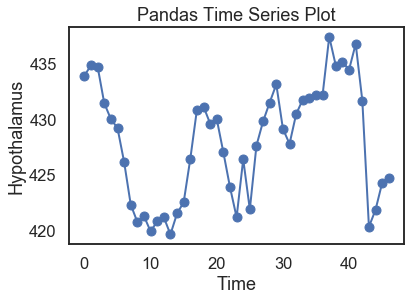

In [212]:
# Plot
df.set_index("time")
# plt.plot(df["insulin_uIU_mL"], marker='o')
# plt.plot(df["glucose_mg_dL"], marker='o')
plt.plot(df["HTH"], marker='o')

# Labelling 

plt.xlabel("Time")
plt.ylabel("Hypothalamus")
plt.title("Pandas Time Series Plot")

# Display

plt.show()

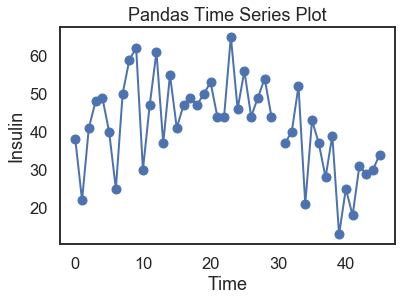

In [213]:
# Plot
df.set_index("time")
plt.plot(df["insulin_uIU_mL"], marker='o')
# plt.plot(df["glucose_mg_dL"], marker='o')
# plt.plot(df["HTH"], marker='o')

# Labelling 

plt.xlabel("Time")
plt.ylabel("Insulin")
plt.title("Pandas Time Series Plot")

# Display

plt.show()

In [214]:
my_list = df.columns.values.tolist()

In [219]:
my_list = my_list[1:]

In [220]:
my_list

['Ca',
 'NAC',
 'EXA',
 'GPe',
 'GPi',
 'SNc',
 'RN',
 'SNr',
 'PBP',
 'VTA',
 'VeP',
 'HN',
 'HTH',
 'MN',
 'STH',
 'insulin_uIU_mL',
 'glucose_mg_dL']

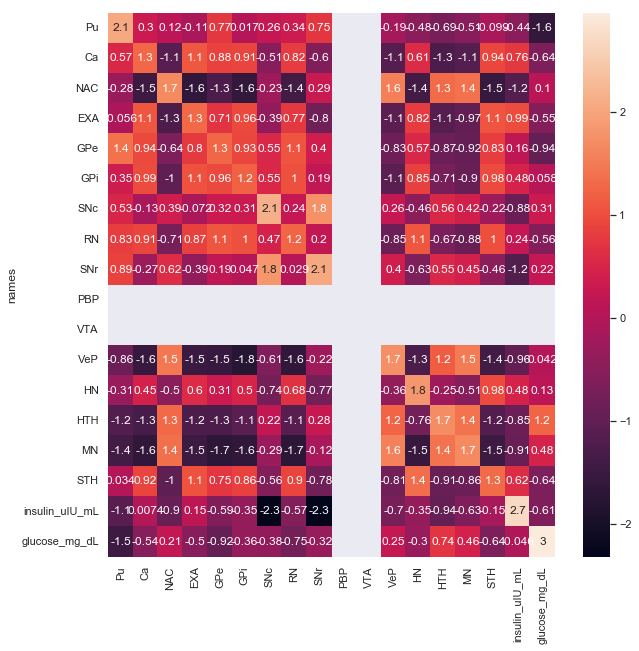

In [85]:
sns.heatmap(cormat, annot=True)

# ICS
From https://naturalistic-data.org/content/Intersubject_Correlation.html

In [221]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 5 seconds


In [223]:
labels = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/CIT168_Reinf_Learn_v1.1.0/labels.csv'
basepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base'
clamppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp'
ppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/'

In [224]:
sub_timeseries = {}
for txtfile in glob.glob(os.path.join(clamppath,'*','total_ts.csv')):
    print(txtfile)
    df = pd.read_csv(txtfile)
    sub = txtfile.split('/')[-2]
    df.reset_index(inplace=True, drop=True)
    df = df.drop(['time','PBP','VTA'], 1)
    sub_timeseries[sub] = df


/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20001/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20003/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20004/total_ts.csv


In [225]:
sub_timeseries

{'20001':             Pu          Ca         NAC         EXA         GPe         GPi  \
 0   390.562030  412.399947  413.464493  505.617857  376.662005  365.381944   
 1   390.768948  412.597540  412.625362  504.898810  376.563170  365.559259   
 2   391.035420  412.537594  412.829469  504.578571  376.739394  365.312037   
 3   392.946303  413.494528  411.943961  504.959524  378.863636  367.272222   
 4   392.115474  412.498235  411.028019  504.478571  377.654779  365.748611   
 5   392.362090  412.491800  410.806280  502.923810  377.906177  364.736574   
 6   393.197689  413.000160  410.812560  503.759524  378.714918  363.367824   
 7   393.515385  413.773066  409.847343  507.297619  378.329837  362.078009   
 8   392.736464  412.538075  409.027053  505.382143  377.250350  360.282407   
 9   393.520170  413.492834  409.279227  506.311905  377.754196  360.521528   
 10  392.878548  412.659465  408.069324  504.384524  376.555478  360.023843   
 11  393.425403  413.389554  408.878502  50

In [226]:
roi = 'HTH'

def get_subject_roi(data, roi):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub][roi]
    return pd.DataFrame(sub_rois)

sub_rois = get_subject_roi(sub_timeseries, roi)
sub_rois.head()

,20001,20002,20003,20004
0,433.913277,352.220480,484.989972,506.252260
1,434.837429,353.007062,485.752542,506.527260
2,434.694209,352.683757,485.505791,506.744915
3,431.431073,352.730226,484.937712,507.548023
4,430.010169,351.620056,486.578814,506.564266


In [227]:
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state

In [228]:
sub_rois= sub_rois.dropna()

In [229]:
stats_circle = isc(sub_rois, method='phase_randomize', n_bootstraps=5000, return_bootstraps=True, n_jobs = 1)

print(f"ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")

ISC: -0.078, p = 0.663


In [117]:
heady = list(sub_timeseries['20001'].columns.values)

In [230]:
for sub,data in sub_timeseries.items():
    print(sub)
    data.dropna(inplace= True)

20001
20002
20003
20004


In [231]:
brraaains = os.path.join('/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas','total_rois_insulin.nii.gz')

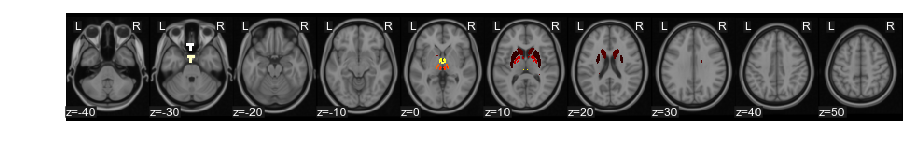

In [232]:
mask = Brain_Data(brraaains)
mask_x = expand_mask(mask)

mask.plot()

In [233]:
isc_r, isc_p = {}, {}
for roi in heady:
    print(roi)
    data = get_subject_roi(sub_timeseries, roi).dropna()
    stats = isc(data, n_bootstraps=5000, metric='median', method='bootstrap', n_jobs = 1)
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']

Pu
Ca
NAC
EXA
GPe
GPi
SNc
RN
SNr
VeP
HN
HTH
MN
STH
insulin_uIU_mL
glucose_mg_dL


In [234]:
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_r), mask_x), roi_to_brain(pd.Series(isc_p), mask_x)

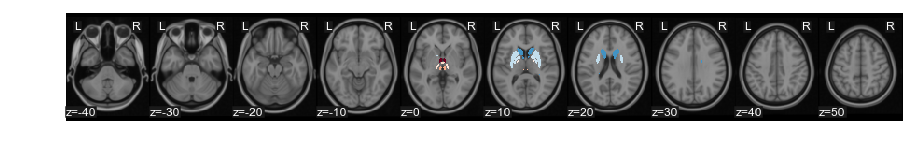

In [235]:
isc_r_brain.plot(cmap='RdBu_r')


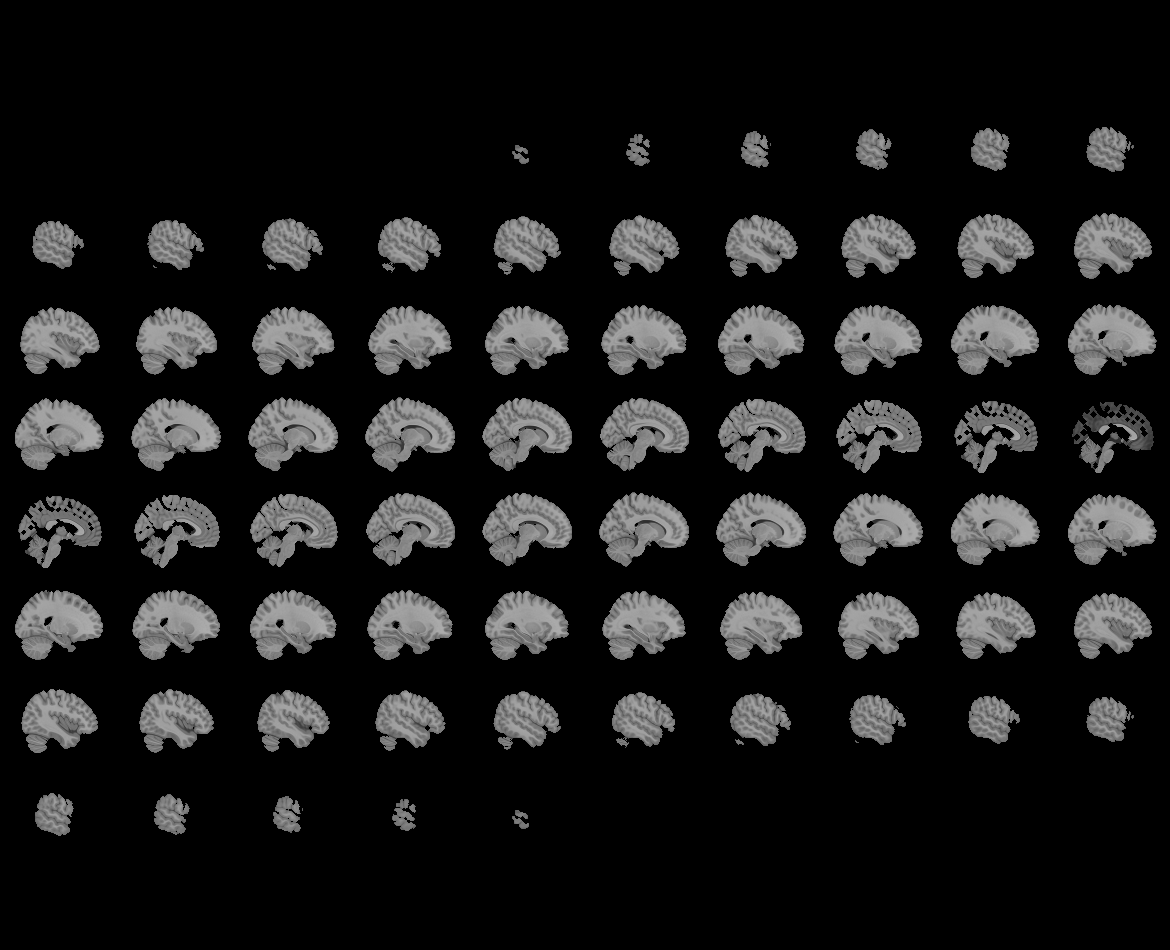
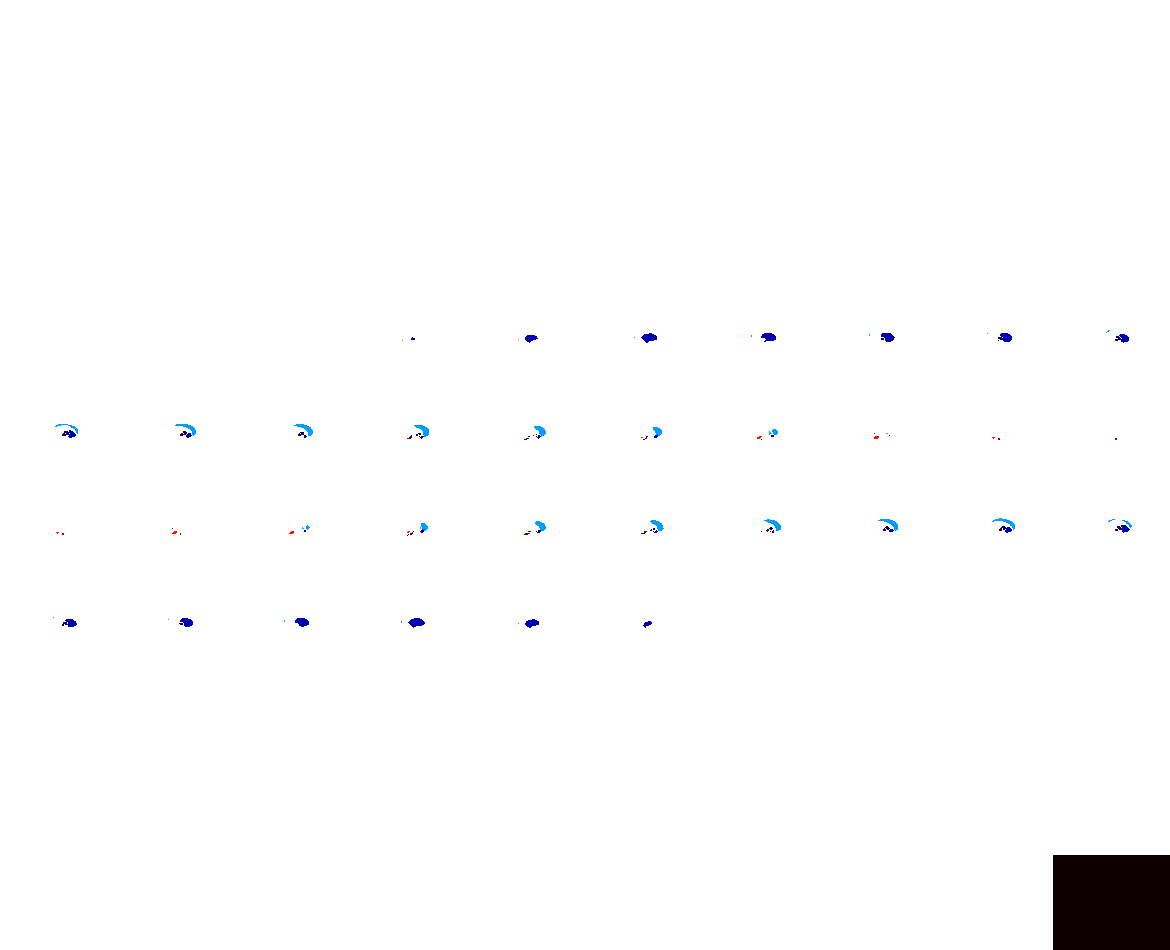

In [236]:
view_img(isc_r_brain.to_nifti())

# ISFC

In [240]:
idx = {}
for sub, data in sub_timeseries.items():
    print(sub)
    print(data)
    idx[sub] = data.index

20001
            Pu          Ca         NAC         EXA         GPe         GPi  \
0   390.562030  412.399947  413.464493  505.617857  376.662005  365.381944   
1   390.768948  412.597540  412.625362  504.898810  376.563170  365.559259   
2   391.035420  412.537594  412.829469  504.578571  376.739394  365.312037   
3   392.946303  413.494528  411.943961  504.959524  378.863636  367.272222   
4   392.115474  412.498235  411.028019  504.478571  377.654779  365.748611   
5   392.362090  412.491800  410.806280  502.923810  377.906177  364.736574   
6   393.197689  413.000160  410.812560  503.759524  378.714918  363.367824   
7   393.515385  413.773066  409.847343  507.297619  378.329837  362.078009   
8   392.736464  412.538075  409.027053  505.382143  377.250350  360.282407   
9   393.520170  413.492834  409.279227  506.311905  377.754196  360.521528   
10  392.878548  412.659465  408.069324  504.384524  376.555478  360.023843   
11  393.425403  413.389554  408.878502  507.197619  377.22

In [244]:
list(idx['20002'])

[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 58]

In [251]:
df_final = {}
for sub, data in sub_timeseries.items():
    print(sub)
    data1 = data[data.index.isin(list(idx['20002']))]
    df_final[sub] = data1[data1.index.isin(list(idx['20001']))]
    

20001
20002
20003
20004


Text(100.40000000000006, 0.5, 'ROI')

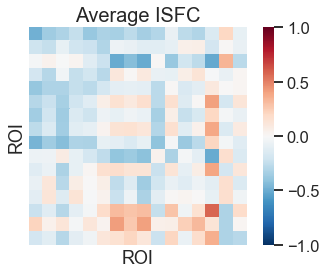

In [254]:
data = list(df_final.values())

isfc_output = isfc(data)

sns.heatmap(np.array(isfc_output).mean(axis=0), vmin=-1, vmax=1, square=True, cmap='RdBu_r', xticklabels=False, yticklabels=False)
plt.title('Average ISFC', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

In [258]:
from scipy.stats import ttest_1samp



Text(100.40000000000006, 0.5, 'ROI')

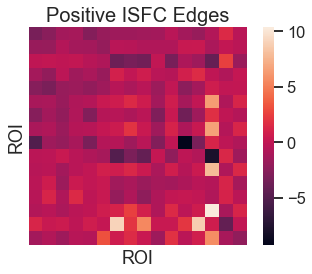

In [272]:
t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)
thresh = fdr(p, .1)
thresholded_t_pos = t.copy()
thresholded_t_pos[p < thresh] = 0
# thresholded_t_pos[thresholded_t_pos <= 0] = 0
# thresholded_t_pos[thresholded_t_pos > 0] = 1
thresholded_t_pos = np.reshape(thresholded_t_pos, isfc_output[0].shape)

sns.heatmap(thresholded_t_pos, square=True, xticklabels=False, yticklabels=False)
plt.title('Positive ISFC Edges', fontsize=20)
plt.xlabel('ROI', fontsize=18)
plt.ylabel('ROI', fontsize=18)

In [285]:
isfc_output

[array([[-0.67383334, -0.11129507, -0.38061467,  0.07383048, -0.32124042,
         -0.02398158, -0.53992136, -0.16679288, -0.68279623, -0.29245581,
          0.19429178, -0.01077289, -0.15729861,  0.03251253,  0.49615099,
          0.38814367],
        [-0.31653294, -0.54565422,  0.32982879, -0.4976817 , -0.42756621,
         -0.48302936, -0.15374287, -0.38725405, -0.24678224,  0.24835195,
         -0.31541207,  0.41706428,  0.35456935, -0.56179911,  0.07140343,
          0.07367029],
        [ 0.05733736, -0.10853574,  0.06119488, -0.14668191, -0.15468016,
         -0.33066276, -0.18419265, -0.29934892, -0.1258661 ,  0.15342732,
         -0.49521923, -0.22090157,  0.10047107, -0.2356143 , -0.06570955,
         -0.33168658],
        [-0.09086773, -0.47477157,  0.35555158, -0.48755799, -0.33748609,
         -0.51577976, -0.07827506, -0.40282111, -0.15568719,  0.28678915,
         -0.49899353,  0.28749759,  0.35621523, -0.59962824, -0.05023815,
         -0.08446348],
        [-0.679873  

In [282]:
import networkx as nx

In [313]:
def plot_network(data):
    '''Plot the degree of the thresholded isfc Adjaceny matrix'''
    
    if not isinstance(data, Adjacency):
        raise ValueError('data must be an Adjacency instance.')
    nodes = {}
    for x in range(16):
        nodes[x] = heady[x]
        
    plt.figure(figsize=(20,15))
    G = data.to_graph()
    G = nx.relabel_nodes(G, nodes, copy=False)
    pos=nx.spring_layout(G)
    
    node_and_degree = G.degree()
    nx.draw_networkx_edges(G, pos, width=3, alpha=.4)
    nx.draw_networkx_labels(G, pos, font_size=14, font_color='black')

    nx.draw_networkx_nodes(G, pos, 
                           node_size=[x[1]*100 for x in node_and_degree],
                           node_color= 'lightblue',
                           cmap=plt.cm.Reds_r, linewidths=2, edgecolors='darkslategray', alpha=1)
    nx.draw_networkx_labels(G, pos)
    
#plot_network(Adjacency(thresholded_t_pos, matrix_type='similarity'))

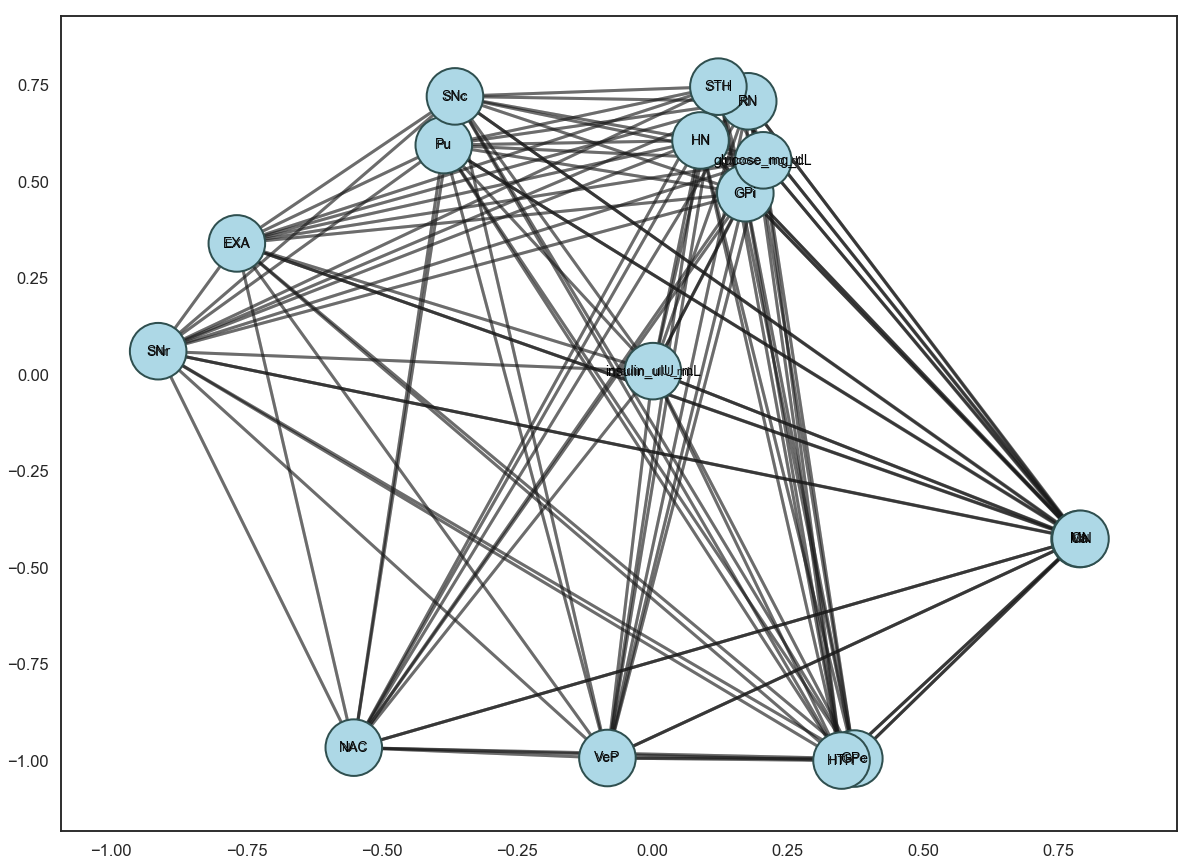

In [314]:
plot_network(Adjacency(thresholded_t_pos))